In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2025-09-26 08:43:26.906649: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-26 08:43:27.831136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-26 08:43:29.231672: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
data = pd.read_csv('train.csv').fillna(0).drop(columns=['date_id', 'forward_returns', 'risk_free_rate'])
data

,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,...,V13,V2,V3,V4,V5,V6,V7,V8,V9,market_forward_excess_returns
0,0,0,0,1,1,0,0,0,1,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003038
1,0,0,0,1,1,0,0,0,1,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.009114
2,0,0,0,1,0,0,0,0,1,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.010243
3,0,0,0,1,0,0,0,0,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004046
4,0,0,0,1,0,0,0,0,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.012301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,0,0,0,0,0,0,0,0,0,1.565379,...,-0.432282,0.785053,0.469577,0.837963,1.226772,0.822751,-0.707361,0.142857,-0.649616,0.001990
8986,0,0,0,0,0,0,0,0,0,1.562946,...,-0.429506,0.767857,0.671958,0.837963,0.785877,0.805556,-0.715692,0.196098,-0.668289,0.001845
8987,0,0,1,0,0,0,0,0,0,1.560520,...,-0.425462,0.734127,0.481481,0.787698,0.834898,0.823413,-0.723949,0.133929,-0.670946,0.002424
8988,0,0,0,0,0,0,0,0,0,1.558102,...,-0.385170,0.695106,0.655423,0.783730,0.994026,0.851852,-0.684937,0.101852,-0.646265,0.007843


In [ ]:
class WindowFrame():
    def __init__(self, input_width:int, label_width:int, shift:int, data:pd.DataFrame, train_val_split:float=0.7, val_test_split:float=0.9, label_columns:list[str]|None=None):
        # store raw data
        n = len(data)
        self.train_df = data[:int(n * train_val_split)]
        self.val_df   = data[int(n * train_val_split):int(n * val_test_split)]
        self.test_df  = data[int(n * val_test_split):]
        # calc label column indices
        self.label_columns = label_columns
        self.label_column_indices = {column: i for i, column in enumerate(label_columns)} if label_columns else None
        self.column_indices = {column: i for i, column in enumerate(data.columns)}
        # calc window params
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_index = np.arange(self.window_size)[self.input_slice]
        self.label_slice = slice(self.window_size-label_width, None)
        self.label_index = np.arange(self.window_size)[self.label_slice]
    
    def split_window(self, features:tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[column]] for column in self.column_indices], axis=-1)
        labels.set_shape([None, self.label_width, None])
        inputs.set_shape([None, self.input_width, None])
        return inputs, labels
    
    def make_dataset(self, data:pd.DataFrame|np.ndarray) -> tf.data.Dataset:
        if not isinstance(data, np.ndarray): data = np.array(data, dtype=np.float32)
        dataset = keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )
        dataset = dataset.map(self.split_window)
        return dataset
    
    @property
    def train_dataset(self) -> tf.data.Dataset:
        return self.make_dataset(self.train_df)

    @property
    def val_dataset(self) -> tf.data.Dataset:
        return self.make_dataset(self.val_df)

    @property
    def test_dataset(self) -> tf.data.Dataset:
        return self.make_dataset(self.test_df)
    
    @property
    def sample_data(self) -> tuple[tf.Tensor, tf.Tensor]:
        sample = getattr(self, '_sample_data', None)
        if sample is None:
            sample = next(iter(self.test_dataset))  
            self._sample_data = sample
        return sample
    
    def plot(self, plot_column:str=None, model:keras.Model|keras.Sequential|None=None, max_subplots:int=3, plot_title:str=None) -> None:
        plot_column = (plot_column or (self.label_columns[0] if self.label_columns is not None else self.train_df.columns[0]))
        inputs, labels = self.sample_data
        plt.figure(figsize=(12, 8))
        if plot_title: plt.title(plot_title)
        plot_col_index = self.column_indices[plot_column]
        max_plots = min(max_subplots, len(inputs))
        for n in range(max_plots):
            plt.subplot(max_plots, 1, n+1)
            plt.plot(self.input_index, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-99)
            label_col_index = (self.label_column_indices.get(plot_column, None) if self.label_columns is not None else plot_col_index)
            if label_col_index is None: continue
            plt.scatter(self.label_index, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='g', s=64)
            if model is not None:
                predictions = model.predict(inputs, verbose=0)
                plt.scatter(self.label_index, predictions[n, :, :],
                            marker='X', edgecolors='k', label='Predictions', c='orange', s=64)
            if n == 0: plt.legend()
        plt.ylabel(f'{plot_column}')
        plt.xlabel('Time Units (Days)')

In [4]:
layers = keras.layers
Sequential = keras.Sequential
keras.utils.set_random_seed(1337)
model = Sequential([
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.LSTM(128, activation='tanh', return_sequences=True),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(64, activation='tanh'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(64, activation='tanh'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.LSTM(128, activation='tanh', return_sequences=True),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(1)],
    name='v1')

model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanAbsoluteError()])

I0000 00:00:1758894210.206944   40271 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9516 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1758894210.207355   40271 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 4723 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5


2025-09-26 08:43:33.766736: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


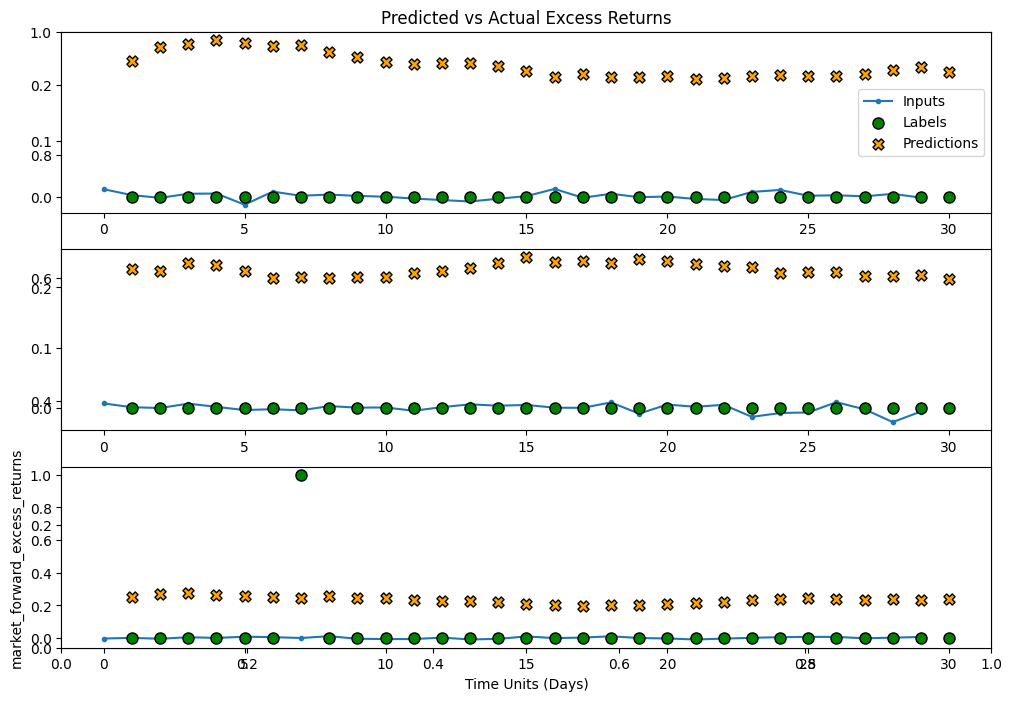

In [5]:
window = WindowFrame(input_width=30, label_width=30, shift=1, data=data, label_columns=['market_forward_excess_returns'])
callbacks = [
    keras.callbacks.TerminateOnNaN(),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
    keras.callbacks.ModelCheckpoint(filepath=f'.models/{model.name}.keras', monitor='val_loss', mode='min', save_best_only=True),
]
model.fit(window.train_dataset, epochs=20, validation_data=window.val_dataset, callbacks=callbacks, verbose=0)
window.plot(model=model, plot_column='market_forward_excess_returns', plot_title='Predicted vs Actual Excess Returns')

In [ ]:
model.predict(window.test_dataset)[0][0][0] # checking how to get predictions out

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


np.float32(0.2221824)